In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/df_ahead_high_low_final.csv', engine='openpyxl')
df.head()

In [ ]:
# Assuming your Excel file has columns named 'feature1', 'feature2', and 'target'
feature1 = df['Feature1'].values.reshape(-1, 1)
feature2 = df['Feature2'].values.reshape(-1, 1)
target = df['Target'].values.reshape(-1, 1)

In [ ]:
# Apply a moving average to smooth the data (adjust the window size as needed)
window_size = 55
feature1_smooth = np.convolve(feature1.flatten(), np.ones(window_size)/window_size, mode='valid')
feature2_smooth = np.convolve(feature2.flatten(), np.ones(window_size)/window_size, mode='valid')
target_smooth = np.convolve(target.flatten(), np.ones(window_size)/window_size, mode='valid')

# Reshape smoothed data
feature1_smooth = feature1_smooth.reshape(-1, 1)
feature2_smooth = feature2_smooth.reshape(-1, 1)
target_smooth = target_smooth.reshape(-1, 1)

In [ ]:
# Create MinMaxScaler objects for feature1 and feature2
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

# Fit and transform your feature vectors
feature1_normalized = scaler1.fit_transform(feature1_smooth)
feature2_normalized = scaler2.fit_transform(feature2_smooth)

In [ ]:
# Create a MinMaxScaler object for the target vector
target_scaler = MinMaxScaler()

# Fit and transform the target vector
target_normalized = target_scaler.fit_transform(target_smooth)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((feature1_normalized, feature2_normalized), axis=1), target_normalized, test_size=0.2, random_state=32)

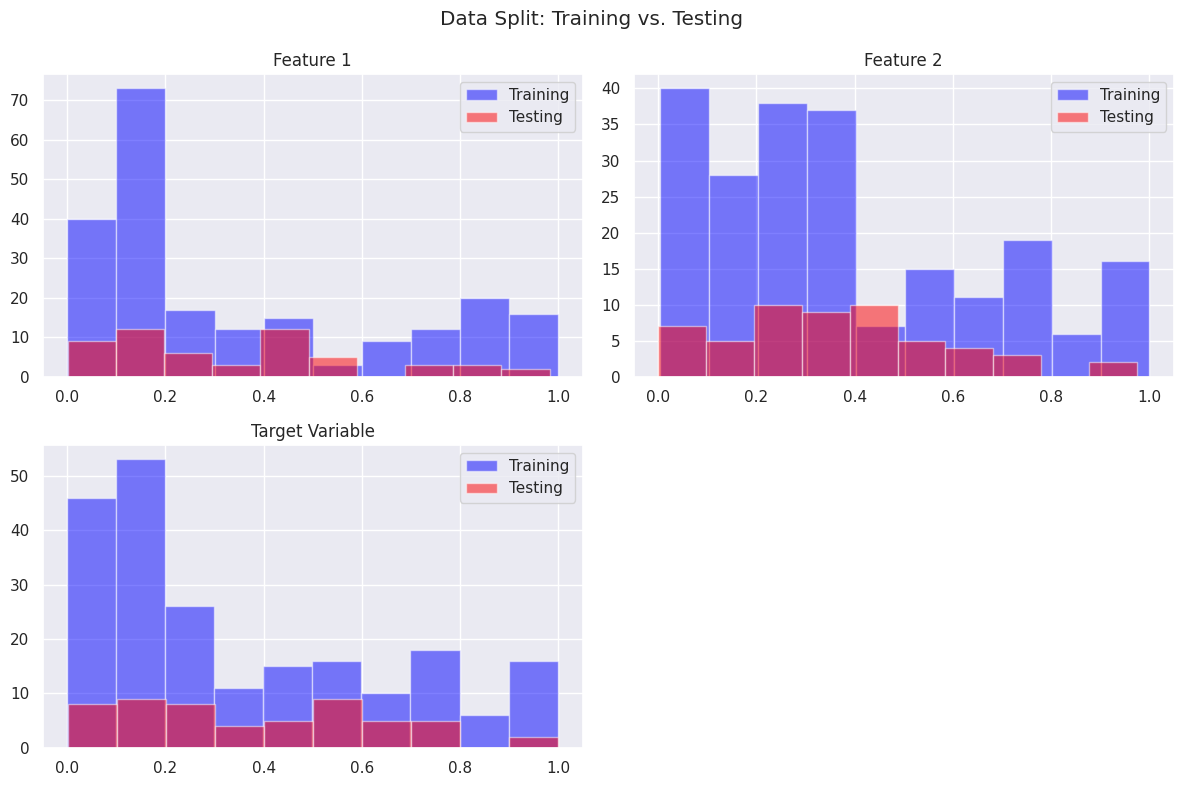

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined X_train, X_test, y_train, and y_test

# Create subplots for feature vectors and target variable
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Data Split: Training vs. Testing")

# Plot histograms for feature1
axs[0, 0].hist(X_train[:, 0], color='blue', alpha=0.5, label='Training')
axs[0, 0].hist(X_test[:, 0], color='red', alpha=0.5, label='Testing')
axs[0, 0].set_title('Feature 1')
axs[0, 0].legend()

# Plot histograms for feature2
axs[0, 1].hist(X_train[:, 1], color='blue', alpha=0.5, label='Training')
axs[0, 1].hist(X_test[:, 1], color='red', alpha=0.5, label='Testing')
axs[0, 1].set_title('Feature 2')
axs[0, 1].legend()

# Plot histograms for the target variable
axs[1, 0].hist(y_train, color='blue', alpha=0.5, label='Training')
axs[1, 0].hist(y_test, color='red', alpha=0.5, label='Testing')
axs[1, 0].set_title('Target Variable')
axs[1, 0].legend()

# Remove the empty subplot
fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [ ]:
print(X_train.shape)

(217, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_lstm_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
    #model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True))
    #model.add(tf.keras.layers.LSTM(8, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(2, activation='linear'))  # The last LSTM layer with 1 unit for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Reshape X_train to include the time step dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


# Define the input_shape
input_shape = (X_train.shape[1], 1)

# Build the model
model = build_lstm_model(input_shape)

# Define a callback to save the model with the lowest validation loss
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Fit the model with the model checkpoint callback (without early stopping)
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[model_checkpoint])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

Epoch 1/150
5/7 [====================>.........] - ETA: 0s - loss: 0.2013 
Epoch 1: val_loss improved from inf to 0.21369, saving model to best_model.h5
7/7 [==============================] - 8s 165ms/step - loss: 0.2117 - val_loss: 0.2137
Epoch 2/150
4/7 [================>.............] - ETA: 0s - loss: 0.2316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.2074
Epoch 2: val_loss improved from 0.21369 to 0.20832, saving model to best_model.h5
7/7 [==============================] - 0s 47ms/step - loss: 0.2074 - val_loss: 0.2083
Epoch 3/150
7/7 [==============================] - ETA: 0s - loss: 0.2025
Epoch 3: val_loss improved from 0.20832 to 0.20222, saving model to best_model.h5
7/7 [==============================] - 0s 43ms/step - loss: 0.2025 - val_loss: 0.2022
Epoch 4/150
7/7 [==============================] - ETA: 0s - loss: 0.1962
Epoch 4: val_loss improved from 0.20222 to 0.19504, saving model to best_model.h5
7/7 [==============================] - 0s 44ms/step - loss: 0.1962 - val_loss: 0.1950
Epoch 5/150
7/7 [==============================] - ETA: 0s - loss: 0.1888
Epoch 5: val_loss improved from 0.19504 to 0.18552, saving model to best_model.h5
7/7 [==============================] - 0s 39ms/step - loss: 0.1888 - val_loss: 0.1855
Epoch 6/150
7/7 [===========================

In [ ]:
y_pred = best_model.predict(X_test)

2/2 [==============================] - 1s 8ms/step


In [ ]:
# Assuming you have already trained your model

# Evaluate the model on the test data
loss = best_model.evaluate(X_test, y_test)

# Print the loss
print(f'Test Loss: {loss}')


2/2 [==============================] - 1s 12ms/step - loss: 0.0073
Test Loss: 0.007289303466677666


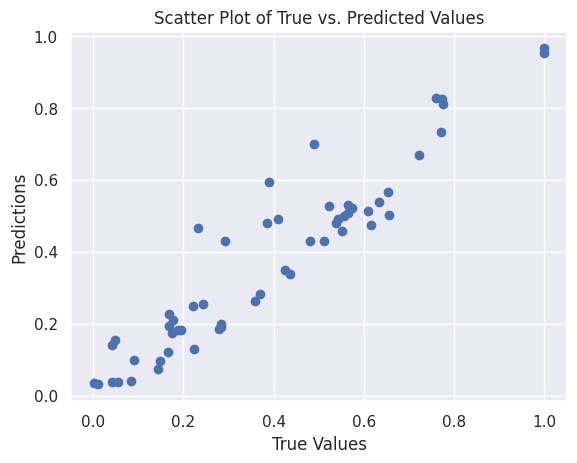

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing code for creating the scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.savefig('/content/drive/MyDrive/Colab/plot1.png')

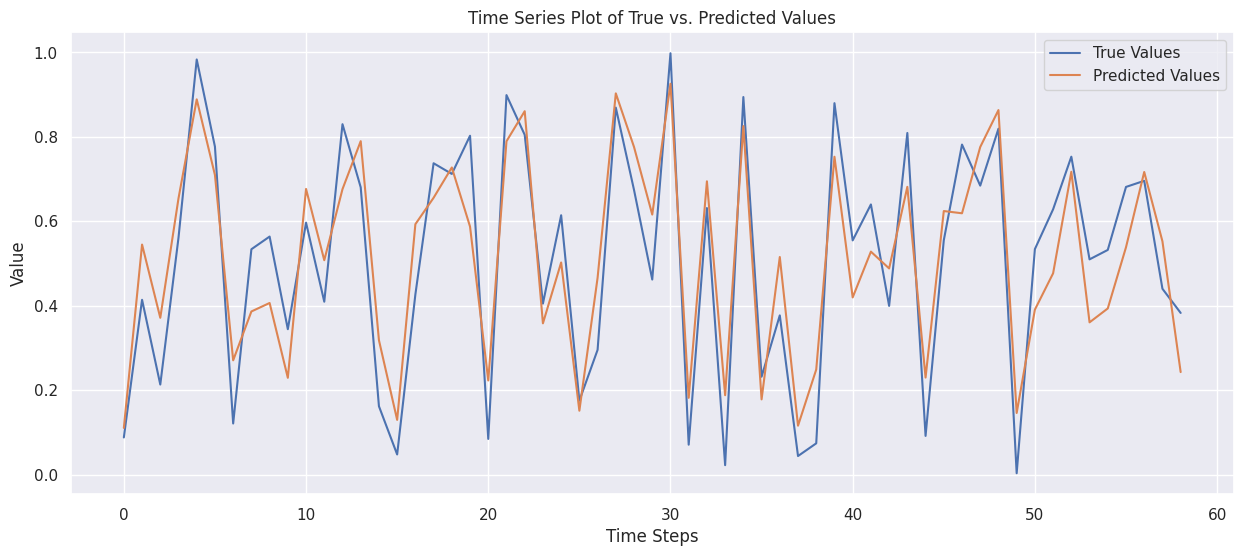

In [ ]:
# Add Seaborn styling
sns.set(style='darkgrid')  # Choose a Seaborn style (you can choose a different one if you prefer)

# Show the plot
plt.show()

# Time Series Plot
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Time Series Plot of True vs. Predicted Values')
plt.savefig('/content/drive/MyDrive/Colab/ts1.png')
plt.legend()

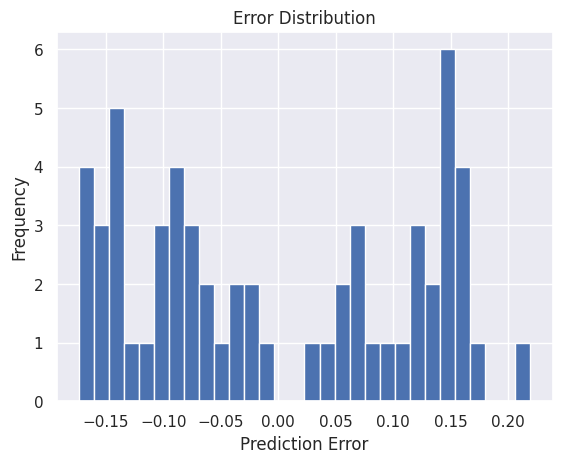

In [ ]:
error = y_test - y_pred
plt.hist(error, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.savefig('/content/drive/MyDrive/Colab/er1.png')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error
import numpy as np

# Calculate the errors
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')
print(f'Explained Variance: {explained_var}')
print(f'Median Absolute Error: {median_ae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 0.007314900835464574
Mean Absolute Error (MAE): 0.0703748684778074
R-squared (R2): 0.8854682418835915
Explained Variance: 0.8893067672673448
Median Absolute Error: 0.06300394406163745
Root Mean Squared Error (RMSE): 0.08552719354371786


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


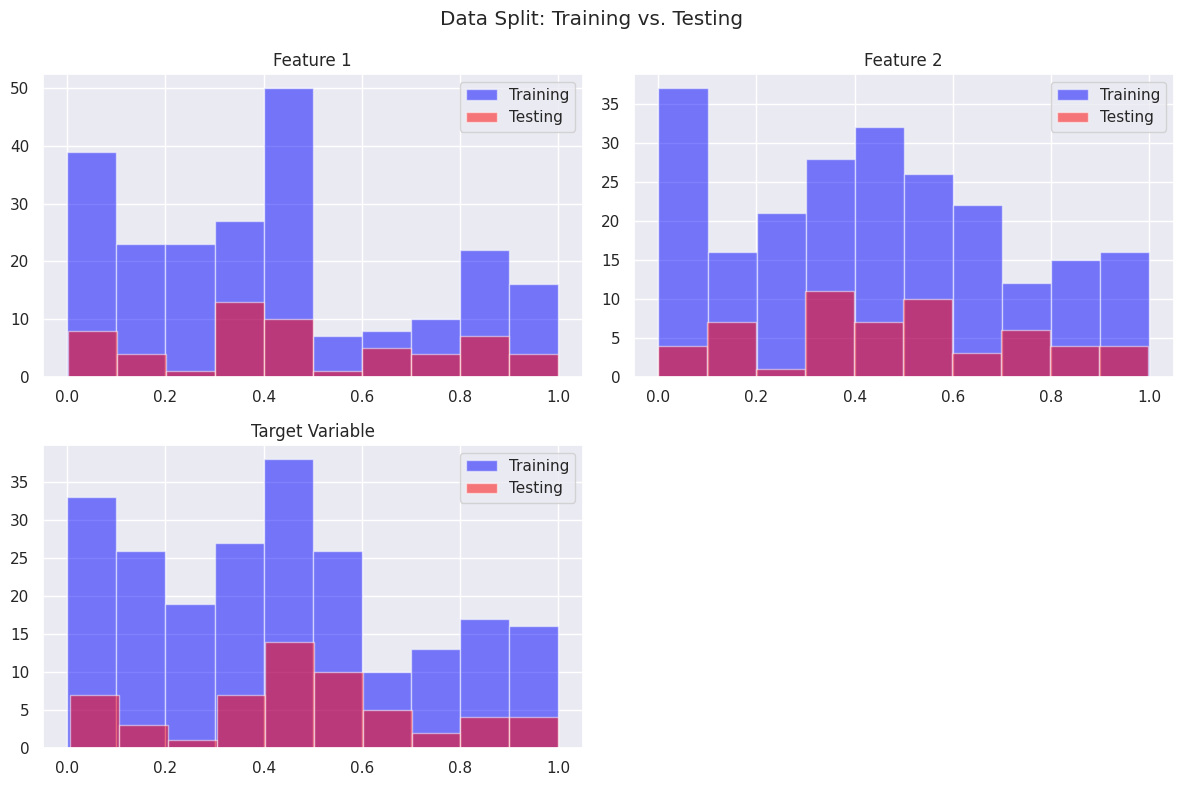

(225, 2)
Epoch 1/150
1/8 [==>...........................] - ETA: 10s - loss: 0.2586
Epoch 1: val_loss improved from inf to 0.26240, saving model to best_model.h5
8/8 [==============================] - 2s 50ms/step - loss: 0.2500 - val_loss: 0.2624
Epoch 2/150
1/8 [==>...........................] - ETA: 0s - loss: 0.2039
Epoch 2: val_loss improved from 0.26240 to 0.23594, saving model to best_model.h5
8/8 [==============================] - 0s 14ms/step - loss: 0.2251 - val_loss: 0.2359
Epoch 3/150
1/8 [==>...........................] - ETA: 0s - loss: 0.1431

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 0.23594 to 0.21101, saving model to best_model.h5
8/8 [==============================] - 0s 13ms/step - loss: 0.2026 - val_loss: 0.2110
Epoch 4/150
1/8 [==>...........................] - ETA: 0s - loss: 0.2490
Epoch 4: val_loss improved from 0.21101 to 0.18617, saving model to best_model.h5
8/8 [==============================] - 0s 17ms/step - loss: 0.1816 - val_loss: 0.1862
Epoch 5/150
1/8 [==>...........................] - ETA: 0s - loss: 0.1836
Epoch 5: val_loss improved from 0.18617 to 0.16015, saving model to best_model.h5
8/8 [==============================] - 0s 12ms/step - loss: 0.1587 - val_loss: 0.1601
Epoch 6/150
1/8 [==>...........................] - ETA: 0s - loss: 0.1383
Epoch 6: val_loss improved from 0.16015 to 0.13263, saving model to best_model.h5
8/8 [==============================] - 0s 14ms/step - loss: 0.1353 - val_loss: 0.1326
Epoch 7/150
1/8 [==>...........................] - ETA: 0s - loss: 0.1134
Epoch 7: val_loss improved from

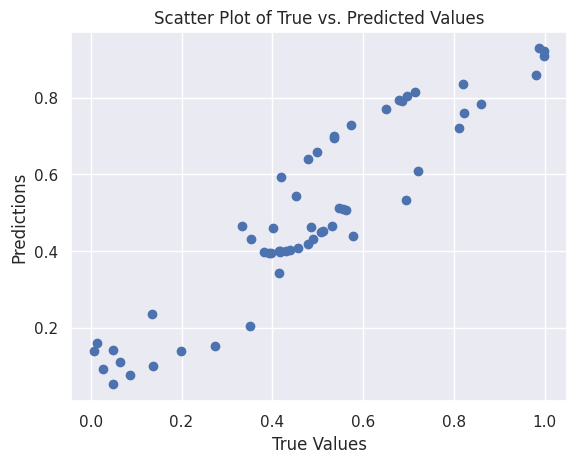

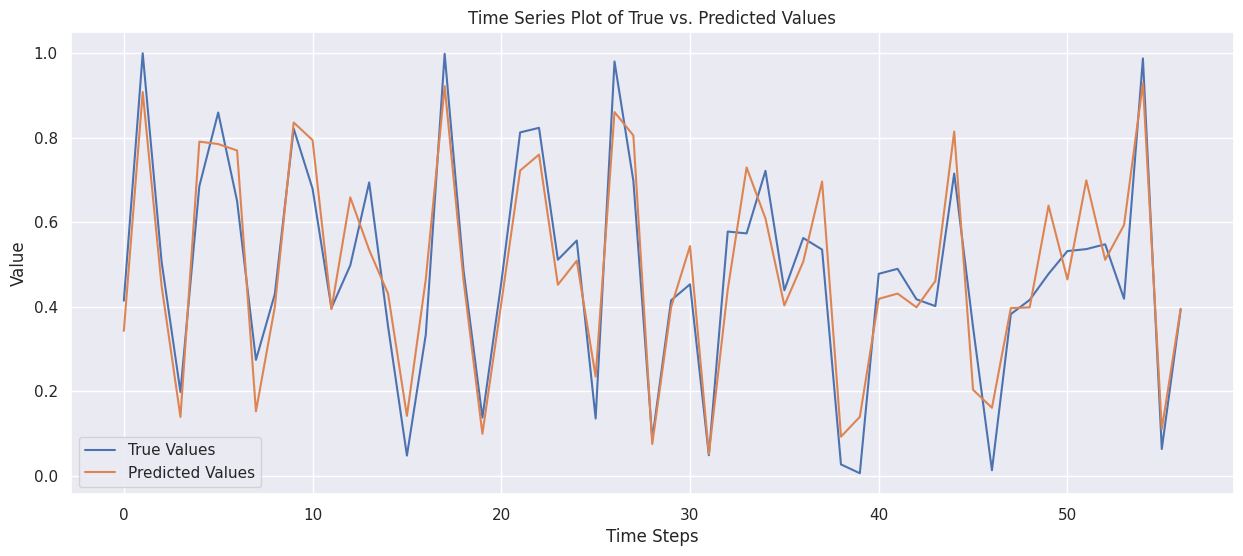

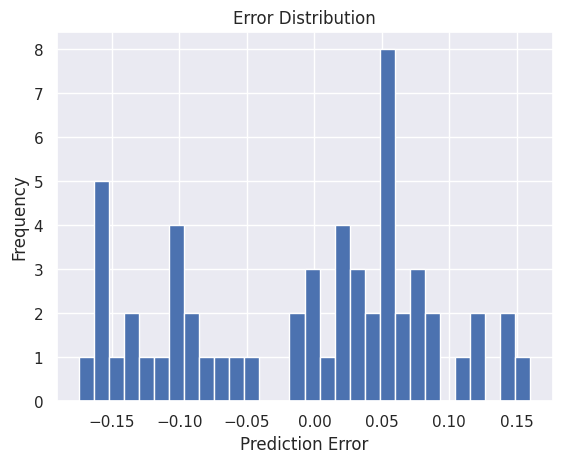

Mean Squared Error (MSE): 0.008830636869200919
Mean Absolute Error (MAE): 0.08015166107254638
R-squared (R2): 0.8643240107664217
Explained Variance: 0.8652004236202784
Median Absolute Error: 0.07142565007937196
Root Mean Squared Error (RMSE): 0.0939714683784441


In [ ]:
%run '/content/drive/MyDrive/Colab/Model_2.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


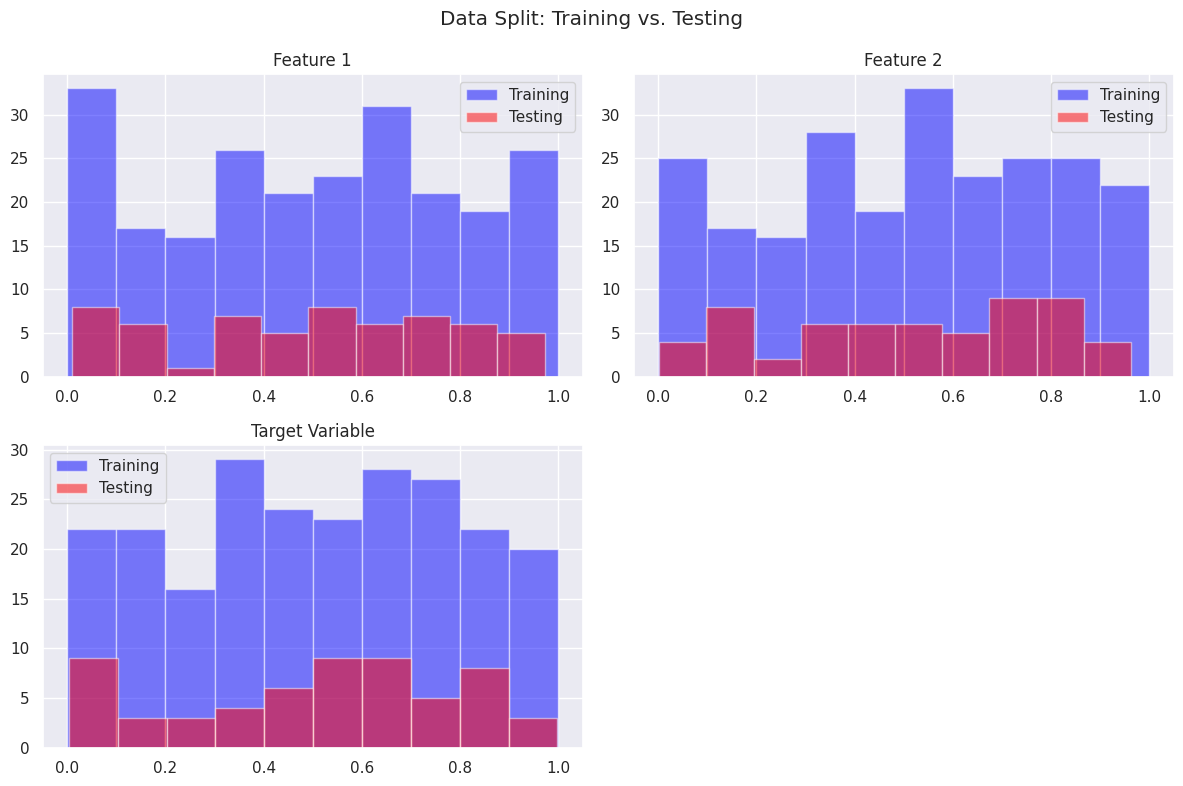

(233, 2)
Epoch 1/50
1/8 [==>...........................] - ETA: 18s - loss: 0.4263
Epoch 1: val_loss improved from inf to 0.38789, saving model to best_model.h5
8/8 [==============================] - 3s 94ms/step - loss: 0.4218 - val_loss: 0.3879
Epoch 2/50
1/8 [==>...........................] - ETA: 0s - loss: 0.4351
Epoch 2: val_loss improved from 0.38789 to 0.34345, saving model to best_model.h5
8/8 [==============================] - 0s 18ms/step - loss: 0.3748 - val_loss: 0.3434
Epoch 3/50
1/8 [==>...........................] - ETA: 0s - loss: 0.3667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 0.34345 to 0.30279, saving model to best_model.h5
8/8 [==============================] - 0s 17ms/step - loss: 0.3306 - val_loss: 0.3028
Epoch 4/50
1/8 [==>...........................] - ETA: 0s - loss: 0.2891
Epoch 4: val_loss improved from 0.30279 to 0.26494, saving model to best_model.h5
8/8 [==============================] - 0s 16ms/step - loss: 0.2904 - val_loss: 0.2649
Epoch 5/50
1/8 [==>...........................] - ETA: 0s - loss: 0.2848
Epoch 5: val_loss improved from 0.26494 to 0.22890, saving model to best_model.h5
8/8 [==============================] - 0s 19ms/step - loss: 0.2534 - val_loss: 0.2289
Epoch 6/50
1/8 [==>...........................] - ETA: 0s - loss: 0.2434
Epoch 6: val_loss improved from 0.22890 to 0.19366, saving model to best_model.h5
8/8 [==============================] - 0s 16ms/step - loss: 0.2171 - val_loss: 0.1937
Epoch 7/50
1/8 [==>...........................] - ETA: 0s - loss: 0.1663
Epoch 7: val_loss improved from 0.1

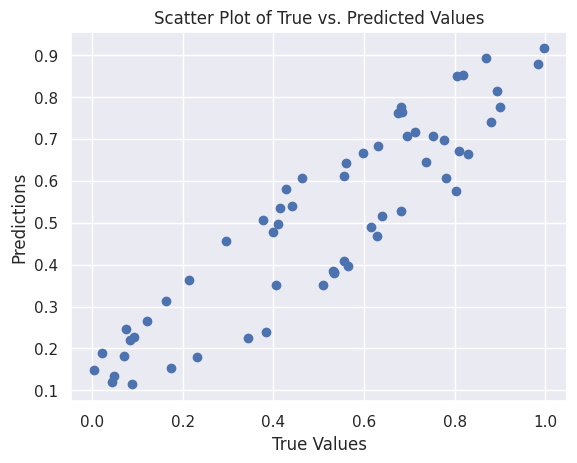

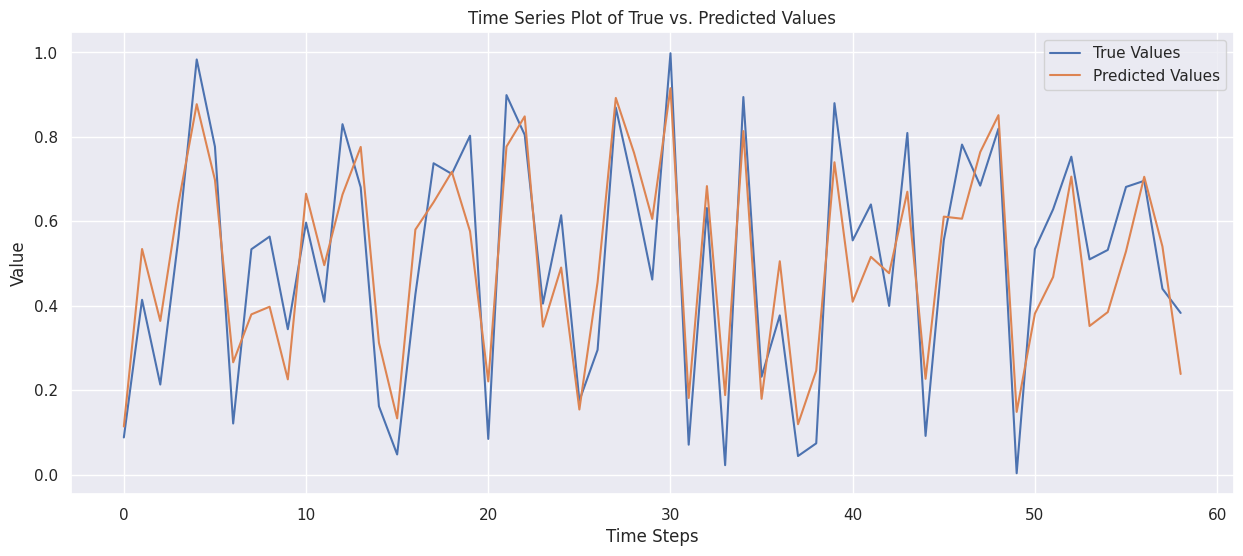

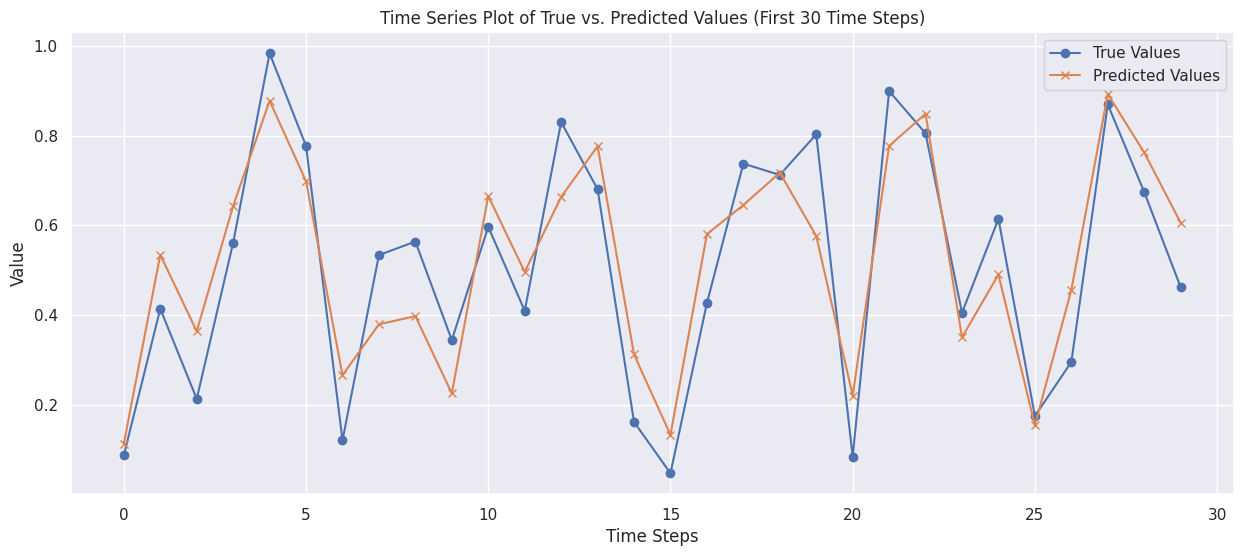

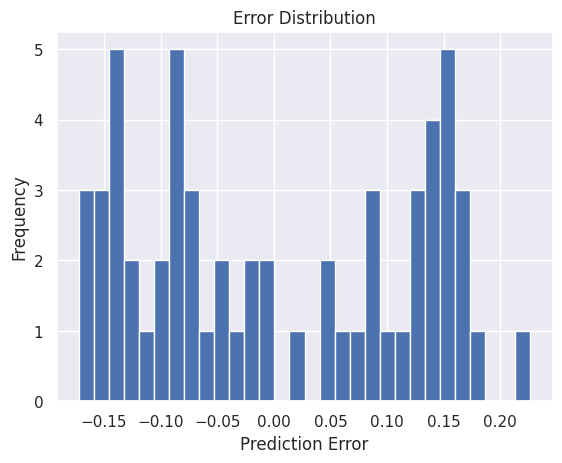

Mean Squared Error (MSE): 0.014304510377342608
Mean Absolute Error (MAE): 0.10906363872800888
R-squared (R2): 0.8150375739296474
Explained Variance: 0.8152344708925109
Median Absolute Error: 0.12031222417863169
Root Mean Squared Error (RMSE): 0.11960146477925179


In [ ]:
%run '/content/drive/MyDrive/Colab/Model_3.ipynb'

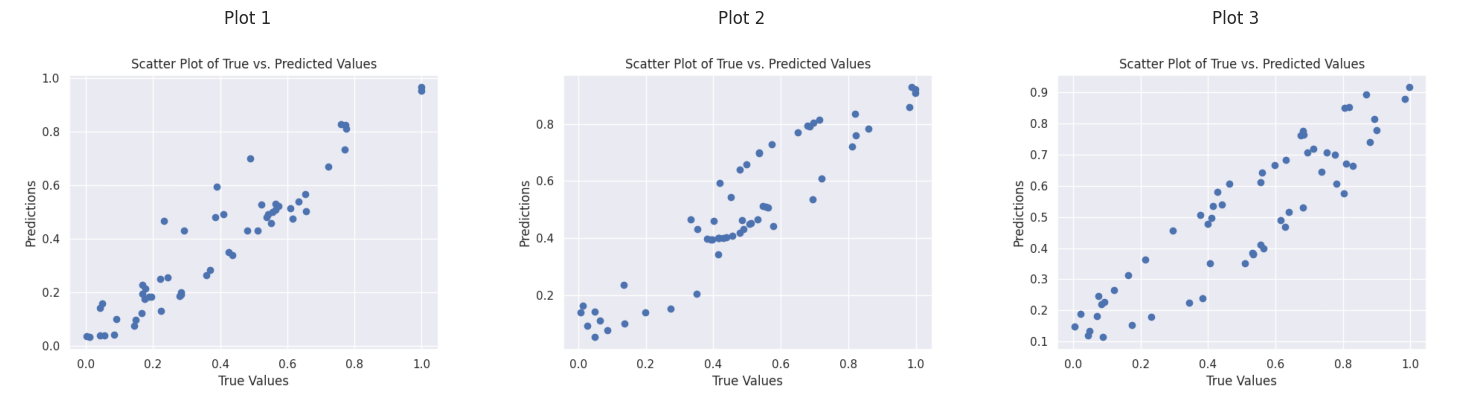

In [ ]:
import matplotlib.pyplot as plt

# Load the generated plots from source notebooks (adjust the variables accordingly)
plot1 = plt.imread('/content/drive/MyDrive/Colab/plot1.png')
plot2 = plt.imread('/content/drive/MyDrive/Colab/plot2.png')
plot3 = plt.imread('/content/drive/MyDrive/Colab/plot3.png')

# Create a single figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

# Display the first plot in the first subplot
axes[0].imshow(plot1)
axes[0].set_title('Plot 1')

# Display the second plot in the second subplot
axes[1].imshow(plot2)
axes[1].set_title('Plot 2')

# Display the third plot in the third subplot
axes[2].imshow(plot3)
axes[2].set_title('Plot 3')

# Remove axis labels if needed
for ax in axes:
    ax.axis('off')

# Show the combined figure
plt.tight_layout()
plt.show()

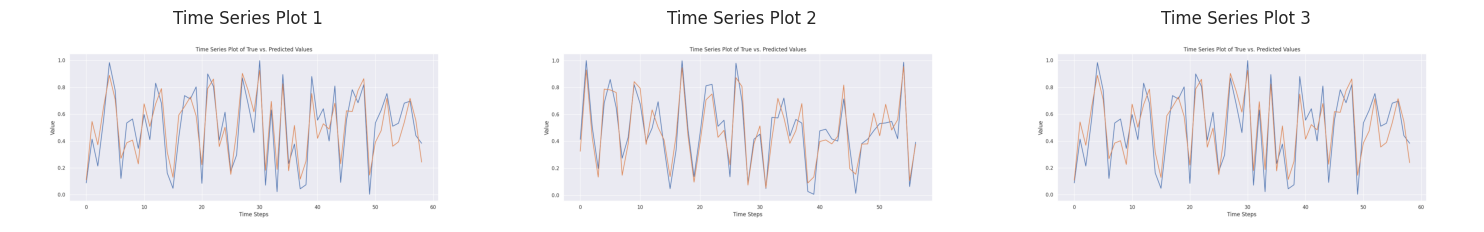

In [ ]:
import matplotlib.pyplot as plt

# Load the generated plots from source notebooks (adjust the variables accordingly)
plot1 = plt.imread('/content/drive/MyDrive/Colab/ts1.png')
plot2 = plt.imread('/content/drive/MyDrive/Colab/ts2.png')
plot3 = plt.imread('/content/drive/MyDrive/Colab/ts3.png')

# Create a single figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

# Display the first plot in the first subplot
axes[0].imshow(plot1)
axes[0].set_title('Time Series Plot 1')

# Display the second plot in the second subplot
axes[1].imshow(plot2)
axes[1].set_title('Time Series Plot 2')

# Display the third plot in the third subplot
axes[2].imshow(plot3)
axes[2].set_title('Time Series Plot 3')

# Remove axis labels if needed
for ax in axes:
    ax.axis('off')

# Show the combined figure
plt.tight_layout()
plt.show()